# Generate scatterplots of CP 1/2/3 mutated position proportions in genes

The goal is showing "outlier" genes with particularly high mutation rates.

In [1]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"
%run "GeneUtils.ipynb"

In [22]:
from parse_sco import parse_sco

def gene_scatterplot_maker(pseudo_variant_caller, output_dict=False, seq2genes_to_highlight={}):
    """Shows scatterplots of mutated position proportions in the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Works similarly to histogram_maker().
        Takes as input two parameters:
            1. cov: an integer describing number of reads aligned to a position (just matches & mismatches)
            2. mismatchct: an integer describing the number of matching reads aligned to a position
            
        Should return a number: 1 if a position is "mutated", 0 if not mutated. Yeah, ideally this would
        return a bool, but numbers make this easier.
        
        We guarantee that cov will be > 0 when this is called -- for positions where cov <= 0, this'll just
        automatically call this position as not mutated.
        
    seq2genes_to_highlight: dict
        Maps sequence names to a dict mapping gene numbers (as ints) to hex colors.
        Selected genes will be enlarged in scatterplots and colored accordingly, so that they can be visually
        emphasized.
    """
    max_cp1_nm = 0
    max_cp2_nm = 0
    max_cp3_nm = 0
    seq2gene2normalizedmutct = {}
    for seq in SEQS:
        df = parse_sco(
            "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq)
        )
        # Go through each gene in this sequence, and compute the (normalized) mutated-position frequency at
        # each of its three codon positions.
        seq2gene2normalizedmutct[seq] = {}
        for gene in df.itertuples():
            i = 1
            cp1_mutct = 0
            cp2_mutct = 0
            cp3_mutct = 0
            for pos in get_pos_interval_from_gene(gene):
                matchct = seq2pos2matchct[seq][str(pos)]
                mismatchct = seq2pos2mismatchct[seq][str(pos)]
                cov = mismatchct + matchct
                if cov > 0:
                    val = pseudo_variant_caller(cov, mismatchct)
                else:
                    print(
                        "Found position with 0 mismatches or matches in {}: pos={} (assigning value of 0)".format(
                            seq, pos
                        )
                    )
                    val = 0
                if val not in [0, 1]:
                    raise ValueError("Output of pseudo_variant_caller should just be an 0 or 1.")
                if i == 1:
                    cp1_mutct += val
                    i = 2
                elif i == 2:
                    cp2_mutct += val
                    i = 3
                elif i == 3:
                    cp3_mutct += val
                    i = 1
                else:
                    raise ValueError("Codon position modulo calculation is broken :|")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")

            onethirdlen = gene.Length / 3
            nm1 = cp1_mutct / onethirdlen
            nm2 = cp2_mutct / onethirdlen
            nm3 = cp3_mutct / onethirdlen
            seq2gene2normalizedmutct[seq][gene.Index] = [nm1, nm2, nm3]
            # Try to update maxima
            max_cp1_nm = max(max_cp1_nm, nm1)
            max_cp2_nm = max(max_cp2_nm, nm2)
            max_cp3_nm = max(max_cp3_nm, nm3)

    # Only do plotting after we've seen all genes in all sequences. This ensures that we know the maximum
    # fraction of (mutated positions / one third gene length) across all CPs in all genes in all sequences.
    # (I mean, the theoretical maximum of this is just 1, in the case where all positions in a CP in a gene
    # are mutated... but that PROBABLY won't happen unless there are some really tiny and/or wacky genes)
    max_cp_nm = max(max_cp1_nm, max_cp2_nm, max_cp3_nm)
    
    
    # Compute scatterplots for CP 1 vs. CP 2 mutated-position frequencies for all genes
    # within this sequence
    def show_cp_vs_cp_plot(seq, x_cp, y_cp, axes):
        """x_cp and y_cp should be 1-indexed CP numbers (one of [1, 2, 3])."""
        if x_cp not in [1,2,3] or y_cp not in [1,2,3]:
            raise ValueError("CPs must be one of [1, 2, 3].")
            
        gene_normalizedmutcts = seq2gene2normalizedmutct[seq].values()
        
        axes.set_title('{}: CP {} vs. CP {}'.format(seq2name[seq], x_cp, y_cp))
        axis_label = "Normalized number of mutated positions in CP {}"
        axes.set_xlabel(axis_label.format(x_cp))
        axes.set_ylabel(axis_label.format(y_cp))
        
        # This is the default size of scatterplot points in matplotlib: see the "s" param docs
        # at https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html.
        dflt_size = (matplotlib.rcParams["lines.markersize"] ** 2)
        
        for gene in seq2gene2normalizedmutct[seq].keys():
            if seq in seq2genes_to_highlight and gene in seq2genes_to_highlight[seq]:
                color = seq2genes_to_highlight[seq][gene]
                # Double "size" of highlighted genes. There is a bit of ambiguity as to what exactly
                # "size" means (area?) -- see https://stackoverflow.com/a/47403507. Rather than spending 30
                # minutes doing a deep dive into this I'm just gonna multiply by four and call it a day
                size = 4 * dflt_size
            else:
                color = SCATTERPLOT_PT_COLOR
                size = dflt_size
            axes.scatter(
                seq2gene2normalizedmutct[seq][gene][x_cp - 1],
                seq2gene2normalizedmutct[seq][gene][y_cp - 1],
                c=color,
                s=size
            )
        
        axes.set_xlim(0, max_cp_nm)
        axes.set_ylim(0, max_cp_nm)
        
        # Plot diagonal line: https://stackoverflow.com/a/22105008
        # Get "ax": https://stackoverflow.com/a/15067854
        axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3")
        
        # Make figure square
#         fig = matplotlib.pyplot.gcf()
#         fig.set_size_inches(6, 6)
        
#         pyplot.show()
    
    # Tile the scatterplots in a grid
    fig, axes = pyplot.subplots(2, 3, gridspec_kw={"hspace": 0.3, "wspace": 0.3})
    for i, seq in enumerate(SEQS):
        show_cp_vs_cp_plot(seq, 1, 2, axes[0, i])        
        show_cp_vs_cp_plot(seq, 1, 3, axes[1, i])
    
    fig.suptitle(
        "Frequencies of mutated positions across genes' CPs",
        fontsize="15",
        y=0.93
    )
    fig.set_size_inches(18, 12)
    fig.savefig("figs/outlier-gene-scatterplots.png", bbox_inches="tight")
        
    if output_dict:
        return seq2gene2normalizedmutct

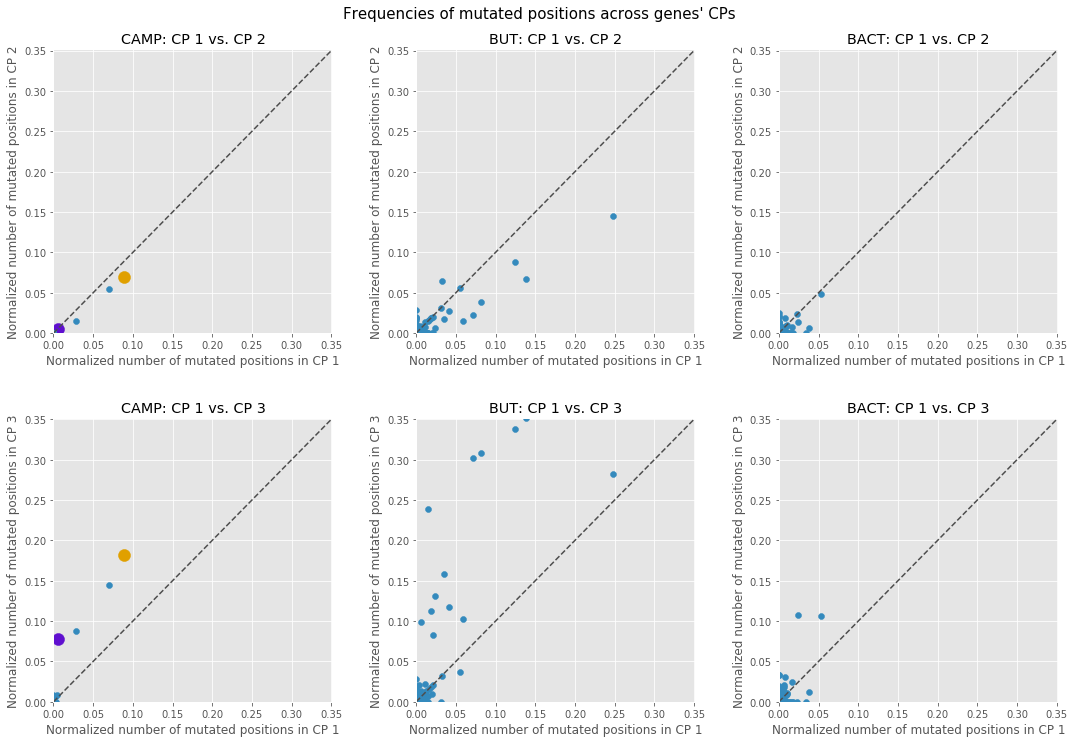

In [23]:
seq2gene2normalizedmutct = gene_scatterplot_maker(
    lambda cov, mismatches: 1 if (mismatches / cov) >= 0.01 else 0,
    True,
    # Gene 1217 (left end 1,208,927; right end 1,210,075) is "G1" in the manuscript [colored purple here]
    # Gene  206 (left end   198,794; right end   200,347) is "G2" in the manuscript [colored golden-ish here]
    {"edge_6104": {1217: "#5F0FCF", 206: "#E0A000"}},
)

In [24]:
# Focus on specific outlier genes in CAMP, manually... (ideally this would be paired with interactive plots
# using Altair or something but installing that is hard)
seq = "edge_6104"
for gene in seq2gene2normalizedmutct[seq]:
    if seq2gene2normalizedmutct[seq][gene][2] > 0.05:
        print(gene, seq2gene2normalizedmutct[seq][gene])

89 [0.02857142857142857, 0.015238095238095238, 0.08761904761904762]
206 [0.0888030888030888, 0.0694980694980695, 0.18146718146718147]
970 [0.07020872865275142, 0.05502846299810247, 0.1442125237191651]
1217 [0.005221932114882507, 0.005221932114882507, 0.0783289817232376]
